In [2]:
# Import libraries
from functools import reduce
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt, exp
from pandas_datareader.data import DataReader
import requests_cache
%matplotlib inline

In [62]:
# Download data from pandas datareader -> AAPL.O, IBM.N, GOOG.O, BP.N, XOM.N, COST.O, GS.N
# Start: 01/01/2016
# End: 31/12/2016
# Create a dictionary: Key -> Ticker, Value -> Historical data from Start_Date to End_Date

session = requests_cache.CachedSession(cache_name='cache',backend='sqlite')
session.headers = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0',
                   'Accept': 'application/json;charset=utf-8'}

def get_data(tickers, start_date="2016-01-01", end_date="2016-12-31"):
    stocks = dict()
    for ticker in tickers:
        s = DataReader(ticker, 'yahoo', start_date, end_date, session=session)
        s.insert(0, "Ticker", ticker)
        s['Prev Close'] = s['Adj Close'].shift(1)
        s['log_return'] = np.log(s['Adj Close']/s['Prev Close'])
        s['perc_return'] = (s['Adj Close']/s['Prev Close']) - 1
        stocks[ticker] = s
    return stocks

# Initialize the dataset with historical data
stocks = ["AAPL", "IBM", "GOOG", "BP", "XOM", "COST", "GS"]
portfolio = get_data(stocks)

## Question 4a. Using historical daily returns, calculate VaR95% and CVaR95% of portfolio as of 2016/12/31
### Calculate log return of portfolio by multiplying the weights with the log_returns of individual stocks each day
### Find the 5th Percentile worst log_return which is the 95% VaR

In [64]:
# Set weights of stocks in portfolio — ["AAPL", "IBM", "GOOG", "BP", "XOM", "COST", "GS"]
weights = np.array([0.15, 0.2, 0.2, 0.15,0.1,0.15,0.05])

# Create column "Previous Adj Close" by shifting "Adj Close" down 1
# Calculate percentage returns by taking (Adj Close / Previous Adj Close) - 1

for stock in stocks:
    portfolio[stock]['Previous Adj Close'] = portfolio[stock]['Adj Close'].shift(1)
    portfolio[stock]['Perc_return'] = (portfolio[stock]['Adj Close'] / portfolio[stock]['Previous Adj Close']) - 1

# Drop na rows, in this case, 2015-12-31 entry

'''portfolio['AAPL'] = portfolio['AAPL'].dropna()
portfolio['IBM'] = portfolio['IBM'].dropna()
portfolio['GOOG'] = portfolio['GOOG'].dropna()
portfolio['BP'] = portfolio['BP'].dropna()
portfolio['XOM'] = portfolio['XOM'].dropna()
portfolio['COST'] = portfolio['COST'].dropna()
portfolio['GS'] = portfolio['GS'].dropna()'''


portfolio['AAPL'].head(3)

,Ticker,High,Low,Open,Close,Volume,Adj Close,Prev Close,log_return,perc_return,Previous Adj Close,Perc_return
Date,,,,,,,,,,,,
2016-01-04,AAPL,26.342501,25.500000,25.652500,26.337500,270597600.0,24.286833,24.266081,0.000855,0.000855,24.266081,0.000855
2016-01-05,AAPL,26.462500,25.602501,26.437500,25.677500,223164000.0,23.678219,24.286833,-0.025379,-0.025059,24.286833,-0.025059
2016-01-06,AAPL,25.592501,24.967501,25.139999,25.174999,273829600.0,23.214844,23.678219,-0.019764,-0.019570,23.678219,-0.019570


In [93]:
# Create a portfolio dataframe to store perc_return, log_return
portfolio_df = pd.DataFrame()
portfolio_df.insert(0, "Date", portfolio['AAPL'].index)
portfolio_df = portfolio_df.set_index("Date")

In [95]:
dates = portfolio_df.index.values
for d in dates:
    d_perc_return = []
    for ticker in stocks:
        d_perc_return.append(portfolio[ticker].loc[d, 'Perc_return'])
    d_perc_return = np.array(d_perc_return)
    portfolio_df.loc[d, "Portfolio_perc_return"] = np.sum(d_perc_return)


In [110]:
# Convert percentage returns to log returns
portfolio_df['Portfolio_log_return'] = np.log(portfolio_df['Portfolio_perc_return'] + 1)

# Using historical data approach to find 95% VaR -> Find the 5th Percentile worst (log) return
VaR_95 = -1* (portfolio_df['Portfolio_log_return'].quantile([0.05]).values[0])
print(f"The VaR95% of portfolio as of 2016/12/31 is {VaR_95}")

The VaR95% of portfolio as of 2016/12/31 is 0.10586921951621035


## Q4ai. The VaR95% of portfolio as of 2016/12/31 is 0.10586921951621035 or 10.59% (4 sig. fig.) log return loss for 95% confidence.

### To find the CVaR95% or expected shortfall at 95% using Historical Data:
### 1. Find sum of loss returns larger than VaR95%
### 2. Divide sum by number of days * alpha, where alpha = 0.05%


In [114]:
loss_return = 0
for d in dates:
    if portfolio_df.loc[d, 'Portfolio_log_return'] < (-1 * VaR_95):
        loss_return += portfolio_df.loc[d, 'Portfolio_log_return']

CVaR_95 = -1*(loss_return/(len(dates) * 0.05))
print(f"The CVaR95% of portfolio as of 2016/12/31 is {CVaR_95}")


The CVaR95% of portfolio as of 2016/12/31 is 0.17560943012814598


## Q4aii. The CVaR95% or Expected Shortfall of portfolio as of 2016/12/31 is 0.17560943012814598 or 17.56% (4 sig fig) log return loss for 95% confidence.
---

## Q4b. Calculate VaR95% and CVaR95% using parametric method
### Assumption: returns are normally distributed
### Formula of Parametric VaR95% = $VaR^p_t = -\sigma_{PF,t}*\Phi^{-1}_p$, where p = 0.05

In [120]:
# Create a new dataframe for question4b with each stocks' log returns
portfolio_parametric = pd.DataFrame()

# Insert date as index, use AAPL's date or any ticker will do
portfolio_parametric.insert(0, "Date", portfolio['AAPL'].index)
portfolio_parametric = portfolio_parametric.set_index("Date")

for d in dates:
    for ticker in stocks:
        col_perc = ticker + " perc_returns"
        col_log = ticker + " log_returns"
        portfolio_parametric.loc[d, col_perc] = portfolio[ticker].loc[d, 'Perc_return']
        portfolio_parametric.loc[d, col_log] = np.log(portfolio[ticker].loc[d, 'Perc_return']+1)

portfolio_parametric.head(3)


,AAPL perc_returns,AAPL log_returns,IBM perc_returns,IBM log_returns,GOOG perc_returns,GOOG log_returns,BP perc_returns,BP log_returns,XOM perc_returns,XOM log_returns,COST perc_returns,COST log_returns,GS perc_returns,GS log_returns
Date,,,,,,,,,,,,,,
2016-01-04,0.000855,0.000855,-0.012135,-0.012209,-0.022454,-0.022710,-0.006398,-0.006419,-0.006286,-0.006306,-0.012136,-0.012210,-0.017145,-0.017293
2016-01-05,-0.025059,-0.025379,-0.000735,-0.000736,0.000998,0.000997,-0.004185,-0.004194,0.008521,0.008485,0.002444,0.002441,-0.017218,-0.017368
2016-01-06,-0.019570,-0.019764,-0.005006,-0.005018,0.001400,0.001400,-0.020369,-0.020579,-0.008321,-0.008356,-0.009254,-0.009297,-0.024412,-0.024715


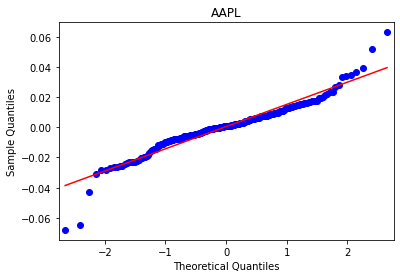

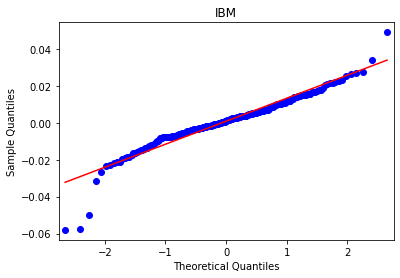

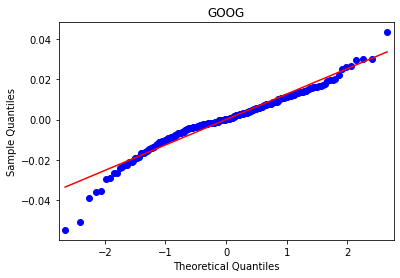

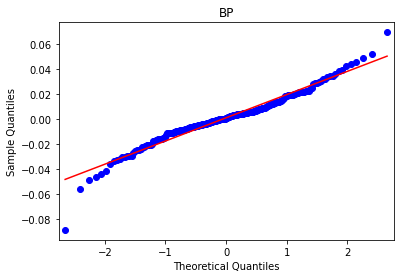

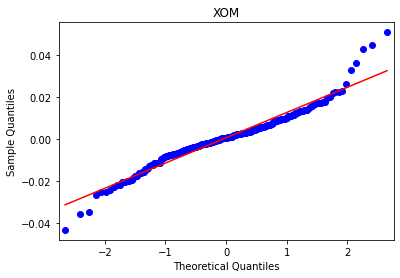

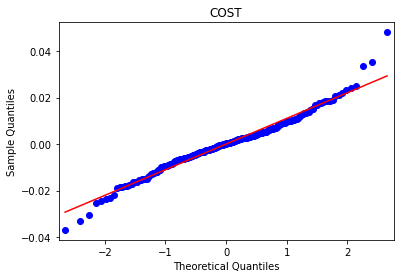

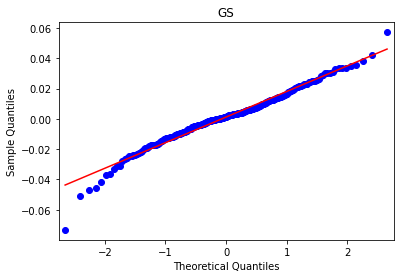

In [176]:
# QQ Plot to check for normality in log_returns
# All closely scattered on the diagonal line with a few deviations
# Especially at the ends which deviates relatively more from the diagonal line
from statsmodels.graphics.gofplots import qqplot
import warnings
warnings.filterwarnings('ignore')

qqplot(portfolio_parametric['AAPL log_returns'], line='s')
plt.title('AAPL')
qqplot(portfolio_parametric['IBM log_returns'], line='s')
plt.title('IBM')
qqplot(portfolio_parametric['GOOG log_returns'], line='s')
plt.title('GOOG')
qqplot(portfolio_parametric['BP log_returns'], line='s')
plt.title('BP')
qqplot(portfolio_parametric['XOM log_returns'], line='s')
plt.title('XOM')
qqplot(portfolio_parametric['COST log_returns'], line='s')
plt.title('COST')
qqplot(portfolio_parametric['GS log_returns'], line='s')
plt.title('GS')

plt.show()


In [177]:
portfolio_parametric.head(3)

,AAPL perc_returns,AAPL log_returns,IBM perc_returns,IBM log_returns,GOOG perc_returns,GOOG log_returns,BP perc_returns,BP log_returns,XOM perc_returns,XOM log_returns,COST perc_returns,COST log_returns,GS perc_returns,GS log_returns
Date,,,,,,,,,,,,,,
2016-01-04,0.000855,0.000855,-0.012135,-0.012209,-0.022454,-0.022710,-0.006398,-0.006419,-0.006286,-0.006306,-0.012136,-0.012210,-0.017145,-0.017293
2016-01-05,-0.025059,-0.025379,-0.000735,-0.000736,0.000998,0.000997,-0.004185,-0.004194,0.008521,0.008485,0.002444,0.002441,-0.017218,-0.017368
2016-01-06,-0.019570,-0.019764,-0.005006,-0.005018,0.001400,0.001400,-0.020369,-0.020579,-0.008321,-0.008356,-0.009254,-0.009297,-0.024412,-0.024715


In [194]:
# Find the mean log return of portfolio
mean_stock_return = portfolio_parametric[['AAPL log_returns', 'IBM log_returns', 'GOOG log_returns', 'BP log_returns', 'XOM log_returns', 'COST log_returns', 'GS log_returns']].mean()
# mean_stock_return

# Convert mean log returns to mean perc returns before getting the weighted mean
returns = np.exp(mean_stock_return.values) - 1
mean_return = np.dot(weights, returns)

# Convert back to weighted mean log returns
mean_log_returns = np.log(1+mean_return)
weighted_mean = mean_log_returns

weighted_mean

0.0005463161572864208

In [189]:
# Find the variance-covariance matrix

mat_df = portfolio_parametric[['AAPL log_returns', 'IBM log_returns', 'GOOG log_returns', 'BP log_returns', 'XOM log_returns', 'COST log_returns', 'GS log_returns']].values
vcv = np.cov(mat_df.T)
# Convert variance-covariance matrix
vcv_perc = np.exp(vcv)-1
vcv_perc

array([[2.16799092e-04, 5.62071553e-05, 8.73304727e-05, 7.92382650e-05,
        4.80110064e-05, 5.13749833e-05, 9.00618213e-05],
       [5.62071553e-05, 1.56094557e-04, 5.44175624e-05, 9.56953604e-05,
        6.53709973e-05, 2.47656503e-05, 9.10756969e-05],
       [8.73304727e-05, 5.44175624e-05, 1.59624959e-04, 4.87988992e-05,
        2.96416375e-05, 5.02992015e-05, 6.73494093e-05],
       [7.92382650e-05, 9.56953604e-05, 4.87988992e-05, 3.43085375e-04,
        1.51720805e-04, 2.71045944e-05, 1.69492695e-04],
       [4.80110064e-05, 6.53709973e-05, 2.96416375e-05, 1.51720805e-04,
        1.44408641e-04, 2.18347849e-05, 8.51148558e-05],
       [5.13749833e-05, 2.47656503e-05, 5.02992015e-05, 2.71045944e-05,
        2.18347849e-05, 1.22278029e-04, 4.73509779e-05],
       [9.00618213e-05, 9.10756969e-05, 6.73494093e-05, 1.69492695e-04,
        8.51148558e-05, 4.73509779e-05, 2.87060124e-04]])

In [190]:
# get the percentage variance returns of portfolio
variance_perc = np.dot(weights, np.dot(vcv_perc, weights))
variance_perc

8.244642213246999e-05

In [195]:
# Formula for parametric VaR is mean + volatility*(z_alpha) where z_alpha = inverse CDF of normal dist at alpha = 5%
variance = np.log(variance_perc+1)
volatility = sqrt(variance)
z_alpha = norm.ppf(0.05, loc=0, scale=1)

# 95% VaR
VaR_portfolio = -1*(weighted_mean + volatility*z_alpha)
print(f"The VaR95% calculated using Parametric method is {VaR_portfolio}.")

The VaR95% calculated using Parametric method is 0.014388648953891615.


## Q4bi. The VaR95% of portfolio using Parametric method as of 2016/12/31 is 0.014388648953891615 or 1.44% (4 sig. fig.) log return loss for 95% confidence.

## Parametric CVaR95% or Parametric Expected Shortfall:
$$ ES^P_{t} = \sigma_{PF, t} * \frac{\varphi(\Phi^{-1}_{p})}{p}$$
### where p = alpha (1-confidence level)

In [200]:
CVaR95_parametric = weighted_mean + volatility*(norm.pdf(z_alpha)/(0.05))
print(f"The CVaR95% calculated using Parametric method is {CVaR95_parametric}")

The CVaR95% calculated using Parametric method is 0.019275364936903065


## Q4bii. The CVaR95% or Expected Shortfall calculated using Parametric method is 0.019275364936903065 or 19.28% (4 sig fig) log return loss for 95% confidence.
---